<a href="https://colab.research.google.com/github/christinacdl/Depression_Detection_Text_Classification/blob/main/Detecting_Signs_of_Depression_from_Social_Media_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DepSign-LT-EDI@ACL-2023 Shared Task 4: Detecting Signs of Depression from Social Media Text**

**Christodoulou Christina**




## **ABSTRACT**
---
The paper describes the system for the 4$^{th}$ Shared task on *Detecting Signs of Depression from Social Media Text* at LT-EDI@RANLP 2023, which aimed to identify signs of depression on English social media texts. The solution comprised data cleaning and pre-processing, the use of additional data, a method to deal with data imbalance as well as fine-tuning of two transformer-based pre-trained language models, RoBERTa-Large and DeBERTa-V3-Large. Four model architectures were developed by leveraging different word embedding pooling methods, namely a RoBERTa-Large bidirectional GRU model using GRU pooling and three DeBERTa models using CLS pooling, mean pooling and max pooling, respectively. Although ensemble learning of DeBERTa's pooling methods through majority voting was employed for better performance, the RoBERTa bidirectional GRU model managed to receive the 8$^{th}$ place out of 31 submissions with 0.42 Macro-F1 score.




In [ ]:
'''
from google.colab import drive
import sys
drive.mount('/content/drive')
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers torchvision torch lightning focal_loss_torch pytorch_metric_learning contractions stop_words emoji unidecode ekphrasis -U SentencePiece datasets

In [ ]:
# Import necessary libraries
import argparse
import torch
from torchtext import data, datasets
import random
import re
from datasets import load_dataset
import glob
import spacy
import string
import time
import emoji
import pandas as pd
import seaborn as sns
import math
import numpy as np
import nltk
import pickle
from tqdm import tqdm, trange
import datetime
import gensim
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
import torch.nn as nn
import torch.optim as optim
import collections
from sklearn.utils import resample
from sklearn import metrics
import spacy
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,  matthews_corrcoef
from sklearn.metrics import classification_report
from functools import reduce
import os
import copy
import shutil
import torch.nn.functional as F
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import itertools
from nltk.probability import FreqDist
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler
from transformers import AdamW, get_linear_schedule_with_warmup, AutoConfig, AutoModel, AutoTokenizer, DebertaConfig, DebertaModel, DebertaTokenizer,DebertaV2Config, DebertaV2Model, DebertaV2Tokenizer, BertTokenizer, BertModel,BertConfig, AlbertConfig, AlbertModel, AlbertTokenizer, RobertaModel, RobertaTokenizer, RobertaConfig, LongformerTokenizer, LongformerModel, LongformerConfig, BigBirdConfig, BigBirdModel, BigBirdTokenizer, LEDConfig, LEDModel, LEDTokenizer
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
import torchvision
from typing import Callable
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.utils.class_weight import compute_class_weight
from focal_loss.focal_loss import FocalLoss
from stop_words import get_stop_words
from nltk.corpus import stopwords
from xmlrpc.client import Boolean
from nltk.sentiment import vader
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from pytorch_metric_learning import losses
#from huggingface_hub import notebook_login
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from lightning import Fabric
import contractions
# Download necessary packages
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

stop_words = list(get_stop_words('en'))        #About 900 stopwords
#nltk_words = list(stopwords.words('english')) #About 150 stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
#notebook_login()

In [ ]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   3061 MiB |  13707 MiB |   1900 TiB |   1900 TiB |\n|       from large pool |   3058 MiB |  13698 MiB |   1896 TiB |   1896 TiB |\n|       from small pool |      3 MiB |      8 MiB |      4 TiB |      4 TiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   3061 MiB |  13707 MiB |   1900 TiB |   1900 TiB |\n|       from large pool |   3058 MiB |  13698 MiB |

In [ ]:
# Set up GPU for Training
#if torch.cuda.is_available():
#  device = torch.device('cuda')
#  print(f'There are {torch.cuda.device_count()} GPU(s) available.')
#  print('Device name:', torch.cuda.get_device_name(0))
#else:
#  print('No GPU available, using the CPU instead.')
#  device = torch.device('cpu')

torch.set_float32_matmul_precision('high')
fabric = Fabric(accelerator='cuda', devices = 1 if torch.cuda.is_available() else None, strategy='auto', precision='16-mixed')

fabric.launch()

#accelerator = Accelerator(gradient_accumulation_steps = 4, mixed_precision = 'fp16')
#device = accelerator.device

INFO: Using 16-bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16-bit Automatic Mixed Precision (AMP)


**THE LABELS FOR ALL TASKS**

In [ ]:
# Determine the number of labels in the data and map each of these labels to an index.
labels_to_id = {'not depression': 0 , 'moderate': 1, 'severe': 2}
id_to_labels = {0 : 'not depression', 1 : 'moderate', 2 : 'severe'}
print(f'DepSign-LT-EDI@RANLP-2023 LABELS: \n {labels_to_id}')

DepSign-LT-EDI@RANLP-2023 LABELS: 
 {'not depression': 0, 'moderate': 1, 'severe': 2}


**FUNCTIONS USED**

In [ ]:
# A function that sets seed for reproducibility
def set_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True


# A function that calculates time in seconds and returns a string in the form hh:mm:ss
def calculate_time(elapsed_time):
    # Round to the nearest second
    elapsed_rounded = int(round((elapsed_time)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


# A function that calculates the trainable parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# A function that checks if a directory exists else creates the directory
def check_create_path(path):
  if not os.path.exists(path):
    os.makedirs(path)
    print('Directory created at {}'.format(path))
  else:
    print('Directory {} already exists!'.format(path))


# A function that reads a csv or tsv file, removes missing values and duplicates
def read_a_file(filename):
  # Check first whether a certain file or directory exists
  if os.path.exists(filename):
    print('Current file opened: ',[os.path.join(filename, file) for file in glob.glob(filename)])

    # Find the file extension to open it properly
    find_separator = {'.csv': ',', '.tsv': '\t'}
    basename, format = os.path.splitext(filename)
    assert format in find_separator
    separator = find_separator[format]

    # Read different extensions of files using pandas with 2 different separators
    read_file = pd.read_csv(filename, sep = separator, encoding = 'utf-8')

    return read_file

  else:
    print('File or directory not accessible. Please check the filename and ensure that the entered path of the file is in "tsv" or "csv" form.')


def open_dataset(dataset_path, text_column, label_column, huggingface_dataset = True, type_split = 1, labelled_dataset = True, preprocess = True):

  if huggingface_dataset:
    if type_split == 1:
      dataset = load_dataset(dataset_path, split='train')
      read_file = pd.DataFrame(dataset)
    elif type_split == 2:
      dataset = load_dataset(dataset_path, split='validation')
      read_file = pd.DataFrame(dataset)
    elif type_split == 3:
      dataset = load_dataset(dataset_path, split='test')
      read_file = pd.DataFrame(dataset)
    else:
      print('Please specify the number "1" for train set, "2" for validation and "3" to use the test set.')

  else:
    read_file = read_a_file(dataset_path)

  read_file.info()

  # Get the keys and their corresponding number of values
  keys = read_file.keys()
  for key in keys:
    df_len = len(read_file[key].unique()) # the length of the unique values of each column
    print('{0:25}{1:10}'.format(key,df_len))

  # Remove missing values and keep the dataFrame with valid entries in the same variable
  read_file.dropna(inplace = True)

  # Remove the index
  read_file.reset_index(inplace = True, drop = True)

  if text_column != 'text':
    read_file = read_file.rename({text_column:'text'}, axis = 1)
  else:
    read_file

  if label_column != 'label':
    read_file = read_file.rename({label_column:'label'}, axis = 1)
  else:
    read_file

  print(read_file.label.value_counts())

  if preprocess:
    print('Applying text preprocessing...')
    read_file.text = read_file.text.apply(lambda x: preprocessing(x))
  else:
    None

  if labelled_dataset:
    # Encode the concatenated data
    encoded_texts = [tokenizer.encode(sent, add_special_tokens = True) for sent in read_file.text.values]

    # Find the maximum length
    max_len = max([len(sent) for sent in encoded_texts])
    print('Maximum sentence length: ', max_len)

    # Find the minimum length
    min_len = min([len(sent) for sent in encoded_texts])
    print('Minimum sentence length: ', min_len)

  else:
    None

  return read_file

In [ ]:
# MY FUNCTIONS FOR DATA PREPROCESSING

def emojis_into_text(sentence):
  demojized_sent = emoji.demojize(sentence)
  emoji_txt = re.sub(r':[\S]+:', lambda x: x.group().replace('_', ' ').replace('-', ' ').replace(':', ''), demojized_sent)
  return emoji_txt

def limit_punctuations(sent, keep_num):
  puncs = ['!', '?', '.']
  for p in puncs:
    sent = _limit_pattern(sent, p, keep_num)
  return sent

def _limit_pattern(sent, pattern, keep_num):
  if pattern in string.punctuation:
    re_pattern = re.escape(pattern)
  else:
    re_pattern = f'(({pattern})[\s]*)'
    pattern = pattern + ' '
  pattern_regex = re_pattern + '{' + str(keep_num+1) + ',}'
  return re.sub(pattern_regex, lambda match: pattern * keep_num, sent)

text_processor = TextPreProcessor(
    # terms that will be normalized
    #normalize = ['user', 'url'],
    # terms that will be annotated
    #annotate = {'hashtag'}, #, 'allcaps'

    # corpus from which the word statistics are going to be used for word segmentation
    segmenter = 'english',

    # corpus from which the word statistics are going to be used for spell correction
    corrector = 'english',

    fix_html = True,  # fix HTML tokens
    fix_text = True,
    unpack_hashtags = True,  # perform word segmentation on hashtags
    unpack_contractions = False,  # Unpack contractions (can't -> can not)
    spell_correct_elong = True,  # spell correction for elongated words

    tokenizer = SocialTokenizer(lowercase = True).tokenize)

def trim_length(text):
  '''
  This method removes the repeating characters that are repeated more than 2 times
  '''
  pat = re.compile(r"(.)\1{2,}")
  return pat.sub(r"\1\1", text)

def word_correct(myStr):
  '''
  This method accepts a string and removes the meta characters from it
  '''
  myStr = str(myStr)
  pat = re.compile(r'[^a-zA-Z1-9]+')
  corrected_str = ''
  splits = myStr.split()
  for word in splits:
    word = word.strip()
    word = re.sub(pat, '', word).lower()
    word = trim_length(word)
    corrected_str = corrected_str+word+' '
  corrected_str = corrected_str.strip()
  return corrected_str

def get_pos(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
              "N": wordnet.NOUN,
              "V": wordnet.VERB,
              "R": wordnet.ADV}
  return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_word(myStr):
  myStr = str(myStr)
  lemmatizer = WordNetLemmatizer()
  lst_word = nltk.word_tokenize(myStr)
  final_str=''
  for word in lst_word:
    word = lemmatizer.lemmatize(word, get_pos(word))
    final_str = final_str+word+' '

  final_str = final_str.strip()
  return final_str

def preprocessing(text):

  # Replace the RT with whitespace
  text = re.sub('RT @\w+: ','', text)

  # Remove the @user tags
  text = re.sub(r'@[A-Za-z0-9_]+','', text)

  # Remove the url links
  text = re.sub(r'http\S+', '', text)

  # Convert the emojis into their textual representation
  text = emojis_into_text(text)

  # Replace '&amp;' with 'and'
  text = re.sub(r'&amp;','and', text)
  text = re.sub(r'&','and', text)

  # Replace the unicode apostrophe
  text = re.sub(r"’","'", text)
  text = re.sub(r":",' ', text)

  text = contractions.fix(text)

  # Replace consecutive non-ASCII characters with whitespace
  text = re.sub(r'[^\x00-\x7F]+',' ', text)

  # Remove the extra whitespace
  text = re.sub(' +',' ',text)

  # Apply the text processor from ekphrasis library
  text = ' '.join(text_processor.pre_process_doc(text))

  text = re.sub(r'\[ removed \]',' ', text)

  # Remove the extra whitespace
  text =  re.sub(' +',' ',text)

  return text


def categorise_sentiment(sentiment, neg_threshold = -0.04, pos_threshold=0.05):
  """ categorise the sentiment value as positive (1), negative (-1) or neutral (0) based on given thresholds """
  if sentiment < neg_threshold:
    label = 2 #'negative' severe
  elif sentiment > pos_threshold:
    label = 1 #'positive' moderate
  else:
    label = 0 #'neutral'
  return label


analyzer = SentimentIntensityAnalyzer()
def vader_sentiment_result(compound):
  #data = str(data)
  #scores = analyzer.polarity_scores(data)
  #neg_threshold = 0.1
  #pos_threshold = 0.3 #0.05

  if compound > 0.05:
    return 0
  elif compound < -0.5:
    return 2
  elif compound >= -0.05 and compound < 0.05:
    return 1

  #if scores["neg"]:
  #  return 1
  #elif scores["pos"]:
  #  return 0
  #else:
  #  return 0


Reading english - 1grams ...
Reading english - 2grams ...
Reading english - 1grams ...


In [ ]:
def compute_class_weights(classes):

  class_weights = compute_class_weight(class_weight = 'balanced',
                                      classes = np.unique(classes),
                                      y = classes)


  print(class_weights)
  return class_weights


class Imbalanced_Dataset_Sampler(torch.utils.data.sampler.Sampler):
  """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments: indices: a list of indices
               num_samples: number of samples to draw
               callback_get_label: a callback-like function which takes two arguments - dataset and index
  """

  def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
    #labels: list = None, indices: list = None, num_samples: int = None, callback_get_label: Callable = None
    # if indices is not provided, all elements in the dataset will be considered
    self.indices = list(range(len(dataset))) if indices is None else indices

    # define custom callback
    self.callback_get_label = callback_get_label

    # if num_samples is not provided, draw `len(indices)` samples in each iteration
    self.num_samples = len(self.indices) if num_samples is None else num_samples

    # distribution of classes in the dataset
    label_to_count = {}
    for idx in self.indices:
      label = self._get_label(dataset, idx)
      if label in label_to_count:
        label_to_count[label] += 1
      else:
       label_to_count[label] = 1

    # weight for each sample
    weights = [1.0 / label_to_count[self._get_label(dataset, idx)]for idx in self.indices]
    self.weights = torch.DoubleTensor(weights)

    # distribution of classes in the dataset
    #df = pd.DataFrame()
    #df['label'] = self._get_labels(dataset) if labels is None else labels
    #df.index = self.indices
    #df = df.sort_index()

    #label_to_count = df['label'].value_counts()

    #weights = 1.0 / label_to_count[df['label']]
    #self.weights = torch.DoubleTensor(weights.to_list())

  def _get_label(self, dataset, idx):
    return dataset.label[idx].item()
  '''
  def _get_labels(self, dataset):
    if self.callback_get_label:
      return self.callback_get_label(dataset)
    elif isinstance(dataset, torch.utils.data.TensorDataset):
      return dataset.tensors[1]
    elif isinstance(dataset, torchvision.datasets.DatasetFolder):
      return dataset.samples[:][1]
    elif isinstance(dataset, torch.utils.data.Subset):
      return dataset.dataset.imgs[:][1]
    elif isinstance(dataset, torch.utils.data.Dataset):
      return dataset.label
    else:
      raise NotImplementedError
  '''
  def __iter__(self):
    return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

  def __len__(self):
    return self.num_samples

In [ ]:
# A function that splits the data into training and validation
def data_splitting(dataframe, text_column, label_column, split_ratio):
  x_train_texts, y_val_texts, x_train_labels, y_val_labels = train_test_split(dataframe[text_column], dataframe[label_column],
                                                                                random_state = 42,
                                                                                test_size = split_ratio,
                                                                                stratify = dataframe[label_column])
  print(f'Dataset split into train and validation/test sets using {split_ratio} split ratio.')
  train_df = pd.concat([x_train_texts, x_train_labels], axis = 1)
  val_df = pd.concat([y_val_texts, y_val_labels], axis = 1)
  print(f'Size of training set: {len(train_df)}')
  print(f'Size of validation/test set: {len(val_df)}')
  return train_df, val_df


def kfoldcross_validation(dataframe, n_folds):
  kf = StratifiedKFold(n_splits = n_folds, random_state = 42, shuffle = True)
  for train_index, val_index in kf.split(dataframe.text, dataframe.label):
    train_texts, validation_texts = dataframe.text[train_index], dataframe.text[val_index]
    train_labels, validation_labels = dataframe.label[train_index], dataframe.label[val_index]
  train_df = pd.concat([train_texts, train_labels], axis = 1)
  validation_df = pd.concat([validation_texts, validation_labels], axis = 1)
  print('Dataset split into train and validation sets using Stratified {} Fold Cross Validation.'.format(n_folds))
  return train_df, validation_df


# A class that creates the necessary input for a pretrained model
class Data_Preparation(torch.utils.data.Dataset):

  def __init__(self, text, label, tokenizer, max_len, dataframe): #, compound, vader_sentiment

    self.text = text
    self.label = label
    #self.compound_column = compound
    #self.vader_sentiment_column = vader_sentiment
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def get_labels(self):
    return self.label

  def __getitem__(self, index):

    text = str(self.text[index])
    text = " ".join(text.split())
    #vader = self.vader_sentiment_column[index]
    #compound = self.compound_column[index]
    #vad_score = [vader, compound]


    encoding = self.tokenizer.encode_plus(text = text,
                                          text_pair = None,
                                          add_special_tokens = True,      # Add [CLS] and [SEP]
                                          max_length = self.max_len,      # Max length to pad
                                          padding = 'max_length',         # Pad sentence according to max length  'max_length'
                                          truncation = True,              # Truncate the sentences
                                          return_token_type_ids = False,  # Do not return the ids of type tokens
                                          return_attention_mask = True,   # Return attention mask
                                          return_tensors = 'pt')          # Return PyTorch tensor


    if self.label is None:
      return {'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()}
              #'vad_score': torch.tensor(vad_score, dtype = torch.float)}

    else:
      return {'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten(),
              'label': torch.tensor(self.label[index], dtype = torch.long)}
              #'vad_score': torch.tensor(vad_score, dtype = torch.float)} #


def create_data_loader(df, tokenizer, max_len, batch_size, shuffle, sampler = 'train'):

  data = Data_Preparation(text = df.text.to_numpy(),
                          label = df.label.to_numpy(),
                          tokenizer = tokenizer,
                          max_len = max_len,
                          dataframe = df)
                          #compound = df.compound.to_numpy(),
                          #vader_sentiment = df.vader.to_numpy())


  if sampler == 'train':
    sampler = RandomSampler(data) #Imbalanced_Dataset_Sampler(data) #
  elif sampler == 'test':
    sampler = SequentialSampler(data)
  else:
    sampler = None

  return DataLoader(data, batch_size = batch_size, pin_memory = True, sampler = sampler, shuffle = shuffle)


# A function that performs data splitting and creation of dataloaders
def TextSplitDataPreparation(dataframe_1, dataframe_2, split_ratio, tokenizer, max_length, batch_size_train, batch_size_val, procedure_1 = True, split_data = True, kfold_crosval = True, make_dataloaders = True):

  if procedure_1:

    if split_data:
      if kfold_crosval:
        train_df, validation_df = kfoldcross_validation(dataframe_1, n_folds = 10)
      else:
        train_df, validation_df = data_splitting(dataframe_1, 'text', 'label', split_ratio = split_ratio)

      #train_df['compound'] = train_df['text'].apply(vadar_sentiment)
      #train_df['vader'] = train_df['compound'].apply(vader_sentiment_result)

      #validation_df['compound'] = validation_df['text'].apply(vadar_sentiment)
      #validation_df['vader'] = validation_df['compound'].apply(vader_sentiment_result)

      #train_df['label'] = train_df['label'].map(labels_to_id)
      #validation_df['label'] = validation_df['label'].map(labels_to_id)
      weights_classes = compute_class_weights(train_df.label)
      weights_classes = torch.tensor(weights_classes,dtype=torch.float)
      weights_classes = weights_classes.to(fabric.device)

      if make_dataloaders:
        train_dataloader = create_data_loader(df = train_df, tokenizer = tokenizer, max_len = max_length, batch_size = batch_size_train, shuffle = False, sampler = 'train')
        val_dataloader = create_data_loader(df = validation_df, tokenizer = tokenizer, max_len = max_length, batch_size = batch_size_val, shuffle = False, sampler = 'test')
        print('The train and validation dataloaders are ready for training and evaluation.')
        return train_dataloader, val_dataloader, weights_classes, validation_df
      else:
        return train_df, validation_df, weights_classes, validation_df

    else:
      make_dataloaders = False
      train_dataloader = create_data_loader(df = dataframe_1, tokenizer = tokenizer, max_len = max_length, batch_size = batch_size_train, shuffle = False, sampler = 'train')
      val_dataloader = None
      print('The dataframe is not split into train and validation sets.The dataframe converted to train dataloader for training.')

  else:
    weights_classes = compute_class_weights(dataframe_1.label)
    weights_classes = torch.tensor(weights_classes,dtype=torch.float)
    weights_classes = weights_classes.to(fabric.device)
    #dataframe_1['label'] = dataframe_1['label'].map(labels_to_id)
    #dataframe_2['label'] = dataframe_2['label'].map(labels_to_id)
    train_dataloader = create_data_loader(df = dataframe_1, tokenizer = tokenizer, max_len = max_length, batch_size = batch_size_train, shuffle = False, sampler = 'train')
    val_dataloader = create_data_loader(df = dataframe_2, tokenizer = tokenizer, max_len = max_length, batch_size = batch_size_val, shuffle = False, sampler = 'test')
    print('The train and validation dataloaders are ready for training and evaluation.')

    return train_dataloader, val_dataloader, weights_classes, dataframe_2

In [ ]:
class Data_Preparation_Dev_Test(Dataset):

  def __init__(self, text, tokenizer, max_len): #, compound, vader_sentiment
    self.text = text
    self.tokenizer = tokenizer
    self.max_len = max_len
    #self.compound_column = compound
    #self.vader_sentiment_column = vader_sentiment

  def __len__(self):
    return len(self.text)

  def __getitem__(self, index):

    text = str(self.text[index])
    text = " ".join(text.split())
    #vader = self.vader_sentiment_column[index]
    #compound = self.compound_column[index]
    #vad_score = [vader, compound]

    encoding = self.tokenizer.encode_plus(text = text,
                                          text_pair = None,
                                          add_special_tokens = True,      # Add [CLS] and [SEP]
                                          max_length = self.max_len,      # Max length to pad
                                          padding = 'max_length',         # Pad sentence according to max length  'max_length'
                                          truncation = True,              # Truncate the sentences
                                          return_token_type_ids = False,  # Do not return the ids of type tokens
                                          return_attention_mask = True,   # Return attention mask
                                          return_tensors = 'pt')          # Return PyTorch tensor

    return {'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()}
            #'vad_score': torch.tensor(vad_score, dtype = torch.float)}


def create_data_loader_test(df, tokenizer, max_len, batch_size, shuffle, sampler = 'test'):

  data = Data_Preparation_Dev_Test(text = df.text.to_numpy(),
                                   tokenizer = tokenizer,
                                   max_len = max_len)
                                   #compound = df.compound.to_numpy(),
                                   #vader_sentiment = df.vader.to_numpy())
  if sampler == 'test':
    sampler = SequentialSampler(data)
  else:
    sampler = None

  return DataLoader(data, batch_size = batch_size, pin_memory = True, sampler = sampler, shuffle = shuffle)


# A function that evaluates a trained model on a unlabelled development/test set
def evaluate_no_labels(model, test_dataloader):

  print('Predicting labels for {} test sentences...'.format(len(test_dataloader)))

  # Initialize empty list to store the predicted values
  predictions = []

  test_dataloader = fabric.setup_dataloaders(test_dataloader)

  model.eval()

  for batch in tqdm(test_dataloader, desc = 'Evaluation iteration'):

    ids_inputs = batch['input_ids']
    att_masks = batch['attention_mask']
    #vad_scores = batch['vad_score']

    # Calculation of gradient not required during evaluation
    with torch.no_grad():

      # Perform forward propagation  , vad_score = vad_scores , pretrained_outputs, vad_embeddings
      outputs = model(input_ids = ids_inputs, attention_mask = att_masks)

    output = (torch.argmax(outputs, dim = 1)).data.cpu().numpy()
    predictions.extend(output)

  df = pd.DataFrame(predictions, columns=['class_label'])

  return df


def model_evaluation_unlabelled(file, model, id_2_label, saved_filename):

  # Open and read the test file
  unlabelled_opened_file = read_a_file(file)
  #unlabelled_opened_file.text = unlabelled_opened_file.text.apply(lambda x: preprocessing(x))
  # Create the test dataloader
  test_dataloader = create_data_loader_test(df = unlabelled_opened_file, tokenizer = tokenizer, max_len = args['max_seq_length'], batch_size = args['validation_batch_size'], shuffle = False, sampler = 'test')
  # Get the predictions for the unlabelled test dataloader
  predicted_labels = evaluate_no_labels(model, test_dataloader)
  # Combine the ids with the predicted numerical labels
  test_set_predictions = pd.concat([unlabelled_opened_file.Pid, predicted_labels], axis = 1)
  test_set_predictions.rename(columns = {'Pid':'pid'}, inplace = True)
  # Convert the numerical labels into categorical labels
  test_set_predictions.class_label.replace(id_2_label, inplace = True)
  # Save the file in csv form
  test_set_predictions.to_csv(saved_filename, encoding = 'utf-8', index = False, header = True, sep ='\t')

  return test_set_predictions, unlabelled_opened_file


# A function that evaluates a trained model
def test(model, test_dataloader):

  print('Predicting labels for {} test sentences...'.format(len(test_dataloader)))

  # Initialize empty lists to store the true values and the predicted values
  true_labels = []
  predictions = []

 # test_dataloader = fabric.setup_dataloaders(test_dataloader)

  model.eval()

  for batch in tqdm(test_dataloader, desc = 'Evaluation iteration'):

    ids_inputs = batch['input_ids']
    att_masks = batch['attention_mask']
    targets = batch['label']
    #vad_scores = batch['vad_score']

    # Calculation of gradient not required during evaluation
    with torch.no_grad():

      # Perform forward propagation  #
      outputs = model(input_ids = ids_inputs, attention_mask = att_masks)

    output = (torch.argmax(outputs, dim = 1)).data.cpu().numpy()
    predictions.extend(output)
    true_labels += targets.flatten().cpu().numpy().tolist()

  # Calculate the metrics to evaluate model performance
  calculate_metrics(true_labels, predictions)

  df = pd.DataFrame(predictions, columns=['class_label'])

  return df

In [ ]:
# A function that saves a pretrained model
def save_model(model, experiment_name, model_output_dir):
  if not os.path.exists(model_output_dir):
    os.makedirs(model_output_dir)
  output_model_file = os.path.join(model_output_dir, experiment_name)
  model_to_save = model.module if hasattr(model, 'module') else model # Take care of distributed/parallel training
  torch.save(model_to_save.state_dict(), output_model_file)
  torch.save(model_to_save, output_model_file)
  #print('Model saved to {} as {}'.format(model_output_dir, experiment_name))

# A function that loads a pretrained model
def load_saved_model(defined_model, experiment_name, model_output_dir):
  saved_model_path = os.path.join(model_output_dir, experiment_name)
  if experiment_name.endswith('.pth'):
    loaded_model = defined_model.load_state_dict(torch.load(saved_model_path))
    print('Model loaded successfully')
  if experiment_name.endswith('.pt'):
    loaded_model  = torch.load(saved_model_path)
    print('Model loaded successfully')
  else:
    print('No such model found.')
  return loaded_model

def save_ckp(state, is_best, checkpoint_path, best_model_path):
  """
  state: checkpoint we want to save
  is_best: is this the best checkpoint; min validation loss
  checkpoint_path: path to save checkpoint
  best_model_path: path to save best model
  """
  f_path = checkpoint_path
  # save checkpoint data to the path given, checkpoint_path
  torch.save(state, f_path)
  # if it is a best model, min validation loss
  if is_best:
    best_fpath = best_model_path
    # copy that checkpoint file to best path given, best_model_path
    shutil.copyfile(f_path, best_fpath)

def load_ckp(checkpoint_path, optimizer):
  """
  checkpoint_path: path to save checkpoint
  model: model that we want to load checkpoint parameters into
  optimizer: optimizer we defined in previous training
  """
  # load check point
  checkpoint = torch.load(checkpoint_path)
  # initialize state_dict from checkpoint to model
  #model.load_state_dict(checkpoint['state_dict'])
  # initialize optimizer from checkpoint to optimizer
  optimizer.load_state_dict(checkpoint['optimizer'])
  # initialize valid_loss_min from checkpoint to valid_loss_min
  valid_loss_min = checkpoint['valid_loss_min']
  # return model, optimizer, epoch value, min validation loss
  return optimizer, checkpoint['epoch'], valid_loss_min   #.item()

In [ ]:
#=== METRICS CALCULATION ===

# Calculates the accuracy per batch, used in the train_model and evaluate_model functions
def accuracy(preds, y_true):

  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = y_true.flatten()
  acc = np.sum(pred_flat == labels_flat) / len(labels_flat)
  #probs = torch.sigmoid(preds.unsqueeze(-1))
  #soft_probs = (probs > 0.5).long()
  #acc = (soft_probs.squeeze() == y_true).float().mean()
  return acc


def plot_roc_curve(true, preds):
  fpr, tpr, threshold = metrics.roc_curve(true, preds)
  roc_auc = metrics.auc(fpr, tpr)
  lw = 2
  # Plot all ROC curves
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc='lower right')
  plt.show()


# A function that plots the confusion matrix with colors and titles
def show_confusion_matrix(true, predicted, class_names):
  cm = confusion_matrix(true, predicted) #, normalize='all'
  df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
  ax = sns.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.2%', cmap='Blues', cbar=False)
  ax.set_title('Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');
  # Ticket labels - List must be in alphabetical order
  ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right')
  ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=30, ha='right')
  # Display the visualization of the Confusion Matrix.
  plt.show()


def show_confusion_matrix1(true, predicted, class_names):
  cm = confusion_matrix(true, predicted)
  df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
  hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Labels')
  plt.xlabel('Predicted Labels')


# A function that calculates all the metrics using the validation/test set
def calculate_metrics(y_true, preds):
  print('\nCalculating metrics...')
  assert len(preds) == len(y_true)

  # Calculate the accuracy of the model
  acc = accuracy_score(y_true, preds)

  # Calculate the Matthews Correlation Coefficient
  # -1 indicates total disagreement between predicted classes and actual classes
  # 0 is synonymous with completely random guessing
  # 1 indicates total agreement between predicted classes and actual classes
  mcc = matthews_corrcoef(y_true, preds)

  # Calculate model's metrics
  model_f1_score = f1_score(y_true, preds, average = 'macro', zero_division = 1)
  model_precision = precision_score(y_true, preds, average = 'macro', zero_division = 1)
  model_recall = recall_score(y_true, preds, average = 'macro', zero_division = 1)

  # Calculate general precision, recall, F1 score of each class
  precision, recall, fscore, support = score(y_true, preds, zero_division = 1)
  print('Accuracy: {}'.format(acc))
  print('F1 score: {}'.format(model_f1_score))
  print('Precision: {}'.format(model_precision))
  print('Recall : {}'.format(model_recall))
  print('Matthews Correlation Coefficient: {}'.format(mcc))
  print('\nPrecision of each class: {}'.format(precision))
  print('Recall of each class: {}'.format(recall))
  print('F1 score of each class: {}'.format(fscore))

  class_names = ['not depression', 'moderate', 'severe']

  # Print the classification report
  print(classification_report(y_true, preds, target_names = class_names, zero_division = 1))

  # Create the confusion matrix
  #show_confusion_matrix(y_true, preds, class_names)

  show_confusion_matrix1(y_true, preds, class_names)

  # Plot the Receiver Operating Characteristic (ROC curve)
  #plot_roc_curve(y_true, preds)

**NECESSARY & IMPORTANT PARAMETERS**

In [ ]:
dict_BERT_model_names = {1: 'bert-base-uncased',
                         2: 'bert-large-uncased'}

dict_AlBERT_model_names = {1: 'albert-base-v1',
                           2: 'albert-base-v2',
                           3: 'albert-xlarge-v1',
                           4: 'albert-xlarge-v2',
                           5: 'albert-xxlarge-v1',
                           6: 'albert-xxlarge-v2'}

dict_RoBERTa_model_names = {1: 'roberta-base',
                            2: 'roberta-large'}

dict_DeBERTa_model_names = {1: 'microsoft/deberta-base',
                            2: 'microsoft/deberta-v2-xlarge',
                            3: 'microsoft/deberta-v2-xxlarge',
                            4: 'microsoft/deberta-v3-large',
                            5: 'microsoft/deberta-xlarge',
                            6: 'microsoft/deberta-large'}

dict_Longformer_model_names = {1: 'allenai/longformer-base-4096',
                              2: 'allenai/longformer-scico',
                              3: 'christinacdl/moderate_severe_depression_longformerlarge_model'}

dict_BigBird_model_names = {1: 'google/bigbird-roberta-base',
                            2: 'google/bigbird-roberta-large',
                            3: 'christinacdl/bigbird_moderate_severe_depression'}

cell_types = {1: 'LSTM',
              2: 'GRU'}

args = {'task_name': 'DepSign-LT-EDI@ACL-2022 Task 4: Detecting Signs of Depression from Social Media Text - LT-EDI@RANLP 2023',
        'data_directory': '/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/train_dev_test_data/',
        'results_data_directory': '/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/results/',
        'output_model_directory': '/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/Models_dir/',
        'model_type':  'roberta',   # Write the model's name
        'model_name': str(dict_RoBERTa_model_names[2]),   # Change the index to train with the model of your choice
        'num_classes': 3,
        'dropout': 0.2,
        'max_seq_length': 512,
        'data_split_ratio': 0.1,
        'train_batch_size': 10, #10
        'validation_batch_size': 16,
        'num_train_epochs': 10,
        'warmup_steps': 0,
        'max_grad_norm' : 1.0,
        'weight_decay':  0.1,
        'learning_rate': 2e-6,
        'adam_epsilon': 1e-8,
        'seed': 42,
        'gradient_accumulation_steps': 2,
        'cell_type': str(cell_types[2]),   # Change the index to train with the model with the RNN cell type of your choice
        'num_layers': 1}

print('================',str(args['task_name']),'================\n')

# Get the directory names and the specific model used
print('Output directory: ' + str(args['output_model_directory']))
print('Model Name: ' + str(args['model_name']))
args['output_specific_model_dir'] = args['output_model_directory'] + args['model_name'] + '/'
print('Output Directory: ' + str(args['output_specific_model_dir']))

# Check whether the directories exist else create them
print('\nChecking that the necessary paths exist...')
check_create_path(args['data_directory'])
check_create_path(args['results_data_directory'])
check_create_path(args['output_model_directory'])
check_create_path(args['output_specific_model_dir'])

MODEL_CLASSES = {'bert': (BertConfig, BertModel, BertTokenizer),
                 'albert': (AlbertConfig, AlbertModel, AlbertTokenizer),
                 'roberta': (RobertaConfig, RobertaModel, RobertaTokenizer),
                 'deberta': (DebertaV2Config, DebertaV2Model, DebertaV2Tokenizer),
                 'longformer':(LongformerConfig, LongformerModel, LongformerTokenizer),
                 'bigbird': (BigBirdConfig, BigBirdModel, BigBirdTokenizer),
                 'other': (AutoConfig, AutoModel, AutoTokenizer)}

config_class, model_class, tokenizer_class = MODEL_CLASSES[args['model_type']]

================ DepSign-LT-EDI@ACL-2022 Task 4: Detecting Signs of Depression from Social Media Text - LT-EDI@RANLP 2023 ================

Output directory: /content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/Models_dir/
Model Name: roberta-large
Output Directory: /content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/Models_dir/roberta-large/

Checking that the necessary paths exist...
Directory /content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/train_dev_test_data/ already exists!
Directory /content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/results/ already exists!
Directory /content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/Models_dir/ already exists!
Directory /content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/Models_dir/roberta-large/ already exists!


**INITIALIZE THE PRETRAINED MODEL AND ITS TOKENIZER**

In [ ]:
# Set seed for reproducibility
set_seed(args['seed'])

config = config_class.from_pretrained(args['model_name'],
                                      num_labels = args['num_classes'],
                                      finetuning_task = args['task_name'])

tokenizer = tokenizer_class.from_pretrained(args['model_name'], do_lower_case = False)

if tokenizer.pad_token is None:
  tokenizer.add_special_tokens({'pad_token': '[PAD]'})

the_pretrained_model = model_class.from_pretrained(args['model_name'],
                                                   num_labels = args['num_classes'], # The number of output labels
                                                   output_attentions = False,        # Whether the model returns attentions weights
                                                   output_hidden_states = True)

the_pretrained_model.resize_token_embeddings(len(tokenizer))

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(50265, 1024, padding_idx=1)

**LOAD THE TRAIN DATASET**

Token indices sequence length is longer than the specified maximum sequence length for this model (715 > 512). Running this sequence through the model will result in indexing errors


Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/train_dev_test_data/train_data.csv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7201 entries, 0 to 7200
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   PID        7201 non-null   object
 1   Text data  7201 non-null   object
 2   Label      7201 non-null   object
dtypes: object(3)
memory usage: 168.9+ KB
PID                            7201
Text data                      7006
Label                             3
moderate          3678
not depression    2755
severe             768
Name: label, dtype: int64
Maximum sentence length:  5753
Minimum sentence length:  5
Number of duplicates in the file: 116
Number of duplicates in the file: 0
moderate          3544
not depression    2697
severe             728
Name: label, dtype: int64


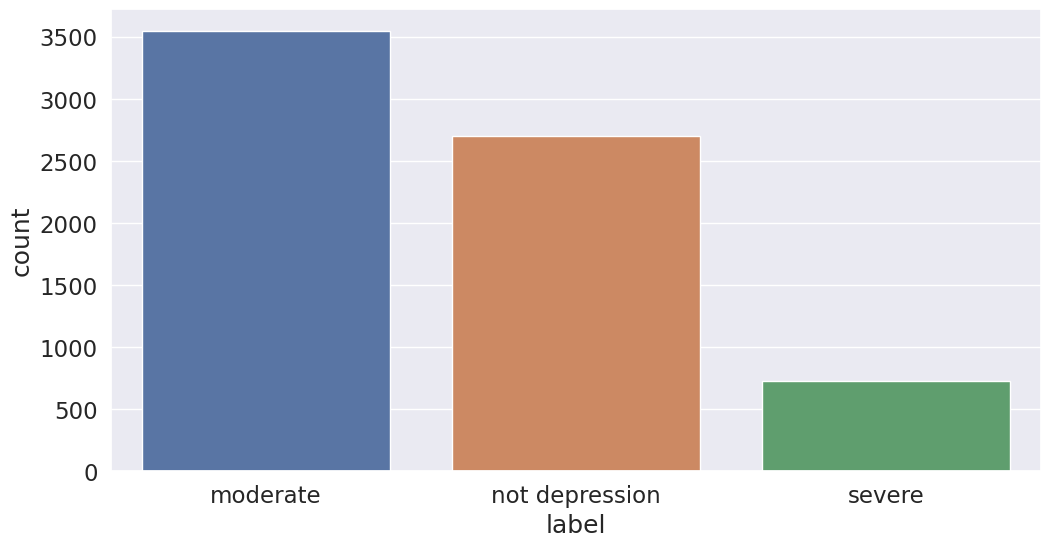

In [ ]:
train_dataset = open_dataset(args['data_directory'] + 'train_data.csv', 'Text data', 'Label', huggingface_dataset = False, type_split = 1, labelled_dataset = True, preprocess = False)
train_dataset = train_dataset.drop(['PID'], axis=1)
# Replace the categorical values with numeral values for training
#train_dataset.label.replace(labels_to_id, inplace = True)
print('Number of duplicates in the file:', train_dataset.duplicated().sum())
train_dataset.drop_duplicates(keep = False, inplace = True)
print('Number of duplicates in the file:', train_dataset.duplicated().sum())
train_dataset.head(10)
# Get the class distribution
countplot_sexism = sns.countplot(x = train_dataset.label)
print(train_dataset.label.value_counts())

**LOAD THE DEVELOPMENT DATASET**

Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/train_dev_test_data/dev_data.csv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3245 entries, 0 to 3244
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Pid           3245 non-null   object
 1   text data     3245 non-null   object
 2   Class labels  3245 non-null   object
dtypes: object(3)
memory usage: 76.2+ KB
Pid                            3245
text data                      3233
Class labels                      3
moderate          2169
not depression     848
severe             228
Name: label, dtype: int64
Maximum sentence length:  3938
Minimum sentence length:  7
Number of duplicates in the file: 12
Number of duplicates in the file: 0
moderate          2153
not depression     841
severe             228
Name: label, dtype: int64


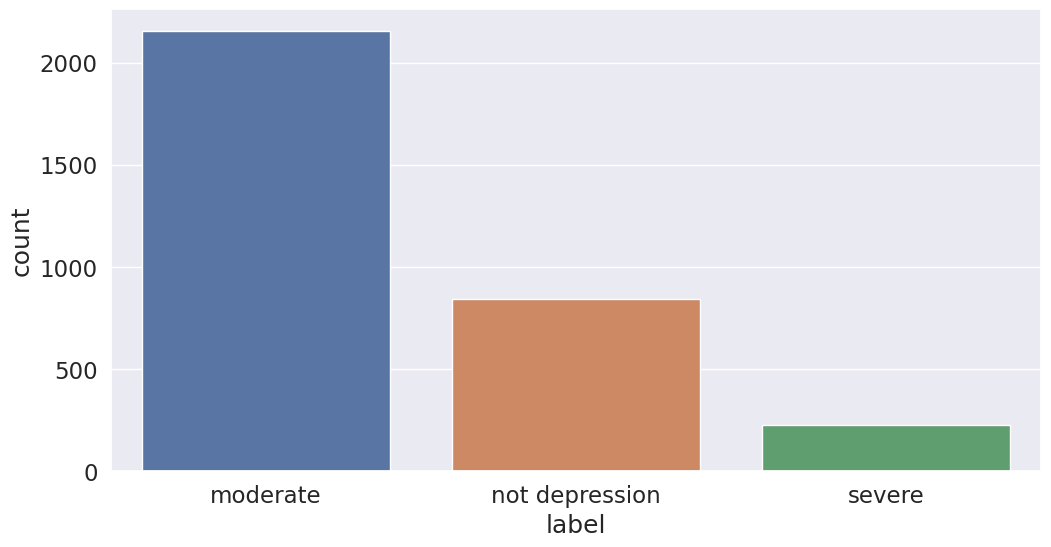

In [ ]:
dev_dataset = open_dataset(args['data_directory'] + 'dev_data.csv', 'text data', 'Class labels', huggingface_dataset = False, type_split = 1, labelled_dataset = True, preprocess = False)
dev_dataset = dev_dataset.drop(['Pid'], axis=1)
print('Number of duplicates in the file:', dev_dataset.duplicated().sum())
dev_dataset.drop_duplicates(keep = False, inplace = True)
print('Number of duplicates in the file:', dev_dataset.duplicated().sum())
dev_dataset.head(10)
countplot_dev = sns.countplot(x = dev_dataset.label)
print(dev_dataset.label.value_counts())

**EXTRA AUXILIARY DEPRESSION DATASETS FROM SOCIAL MEDIA**

In [ ]:
dep_dataset1 = open_dataset(args['data_directory'] + 'depression_dataset_reddit_cleaned.csv', 'clean_text', 'is_depression', huggingface_dataset = False, type_split = 1, labelled_dataset = True, preprocess = False)
print('Number of duplicates in the file:', dep_dataset1.duplicated().sum())
dep_dataset1.drop_duplicates(keep = False, inplace = True)
print('Number of duplicates in the file:', dep_dataset1.duplicated().sum())
dep_dataset1.label.replace([0, 1], ['not depression', 'moderate'], inplace = True)
# Get the class distribution
print(dep_dataset1.label.value_counts())


dep_dataset2 = open_dataset(args['data_directory'] + 'reddit_depression_suicidewatch.csv', 'text', 'label', huggingface_dataset = False, type_split = 1, labelled_dataset = True, preprocess = False)
print('Number of duplicates in the file:', dep_dataset2.duplicated().sum())
dep_dataset2.drop_duplicates(keep = False, inplace = True)
print('Number of duplicates in the file:', dep_dataset2.duplicated().sum())
dep_dataset2.label.replace(['depression', 'SuicideWatch'], ['moderate', 'severe'], inplace = True)
# Get the class distribution
print(dep_dataset2.label.value_counts())

Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/train_dev_test_data/depression_dataset_reddit_cleaned.csv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731 entries, 0 to 7730
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_text     7731 non-null   object
 1   is_depression  7731 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 120.9+ KB
clean_text                     7650
is_depression                     2
0    3900
1    3831
Name: label, dtype: int64
Maximum sentence length:  4342
Minimum sentence length:  4
Number of duplicates in the file: 81
Number of duplicates in the file: 0
not depression    3879
moderate          3718
Name: label, dtype: int64
Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/train_dev_test_data/reddit_depression_suicidewatch.csv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20363 entries, 0 to 2

Number of duplicates in the file: 0
Number of duplicates in the file: 0
moderate          16056
severe            10944
not depression     7417
Name: label, dtype: int64


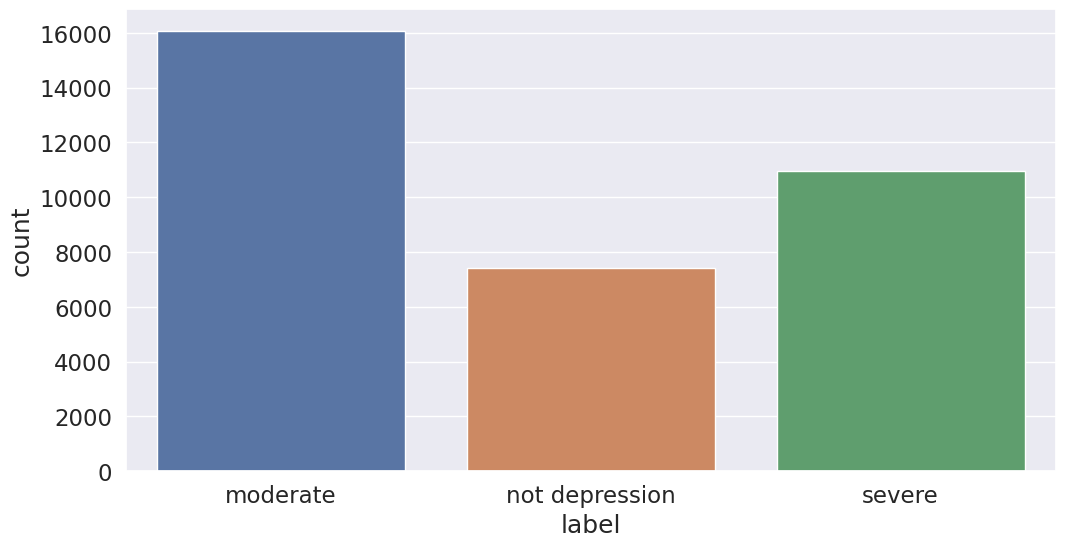

In [ ]:
dep_dataset1_no = dep_dataset1[dep_dataset1['label'] == 'not depression']

new_training_dataset = pd.concat([train_dataset, dev_dataset, dep_dataset2, dep_dataset1_no], axis = 0)
print('Number of duplicates in the file:', new_training_dataset.duplicated().sum())
new_training_dataset.drop_duplicates(keep = False, inplace = True)
print('Number of duplicates in the file:', new_training_dataset.duplicated().sum())
countplot_new_training_dataset = sns.countplot(x = new_training_dataset.label)
print(new_training_dataset.label.value_counts())

**PRE-PROCESS THE TRAIN DATA**

In [ ]:
new_training_dataset.text = new_training_dataset.text.apply(lambda x: preprocessing(x))
new_training_dataset['label'] = new_training_dataset['label'].map(labels_to_id)

# Encode the concatenated data
encoded_texts = [tokenizer.encode(sent, add_special_tokens = True) for sent in new_training_dataset.text.values]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_texts])
print('Maximum sentence length: ', max_len)

#new_training_dataset.to_csv(args['data_directory'] + 'train_depression_dataset.tsv', encoding = 'utf-8', index = False, header = True, sep ='\t')

Maximum sentence length:  9362


**OPEN AND PRE-PROCESS THE UNLABELLED TEST DATA**

In [ ]:
test_set = read_a_file(args['data_directory'] + 'test_data.csv')
print('Number of duplicates in the file:', test_set.duplicated().sum())
test_set.drop_duplicates(keep = False, inplace = True)
print('Number of duplicates in the file:', test_set.duplicated().sum())

test_set.rename(columns = {'Text data':'text'}, inplace = True)

test_set.text = test_set.text.apply(lambda x: preprocessing(str(x)))
#test_set.to_csv(args['data_directory'] + 'original_test_data.tsv', encoding = 'utf-8', index = False, header = True, sep ='\t')

Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/train_dev_test_data/test_data.csv']
Number of duplicates in the file: 0
Number of duplicates in the file: 0


**OPEN THE TRAINING SET**

In [ ]:
training_set = open_dataset(args['data_directory'] + 'train_depression_dataset.tsv', 'text', 'label', huggingface_dataset = False, type_split = 1, labelled_dataset = False, preprocess = False)
training_set.head(10)

Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/train_dev_test_data/train_depression_dataset.tsv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34417 entries, 0 to 34416
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    34417 non-null  object
 1   label   34417 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 537.9+ KB
text                          34315
label                             3
1    16056
2    10944
0     7417
Name: label, dtype: int64


,text,label
0,waiting for my mind to have a breakdown once t...,1
1,my new years resolution : i am going to get my...,1
2,new year : somone else feeling like 2020 will ...,1
3,"my story i guess : hi , i am from germany and ...",1
4,sat in the dark and cried myself going into th...,1
5,i will probably end it when my mum is not arou...,1
6,fuck 2019 : left abusive relationship . moved ...,1
7,i am at a new year ' s eve party and i want to...,1
8,death of my father : my father died in the beg...,1
9,empty and stuck in a loop every day : in any o...,1


**OPEN THE TEST SET (WITH LABELS PROVIDED AFTER THE END OF THE COMPETITION)**

In [ ]:
test_set1 = open_dataset(args['data_directory'] + 'Test_data_with_labels - test_data.csv', 'Text data', 'Label', huggingface_dataset = False, type_split = 1, labelled_dataset = False, preprocess = False)
test_set1.text = test_set1.text.apply(lambda x: preprocessing(x))
test_set1['label'] = test_set1['label'].map(labels_to_id)
test_dataloader = create_data_loader(df = test_set1, tokenizer = tokenizer, max_len = args['max_seq_length'], batch_size = args['validation_batch_size'], shuffle = False, sampler = 'test')
test_set1.head(50)

Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/train_dev_test_data/Test_data_with_labels - test_data.csv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Pid        499 non-null    object
 1   Text data  499 non-null    object
 2   Label      499 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB
Pid                             499
Text data                       499
Label                             3
moderate          275
not depression    135
severe             89
Name: label, dtype: int64


,Pid,text,label
0,test_id_1,"this is me . don get me wrong , it better than...",1
1,test_id_2,i hate that people don understand that i don w...,2
2,test_id_3,"but here i am , 24 years old man and doing exa...",1
3,test_id_4,i trapped inside . does anyone else get that f...,1
4,test_id_5,i read a lot of posts on here of people strugg...,1
5,test_id_6,"thank you , that really helps . now i feel ten...",1
6,test_id_7,i don know if that makes sense . what i mean i...,1
7,test_id_8,does anyone else feel this way ? this has been...,2
8,test_id_9,the first 6 words of the title is accurate too .,1
9,test_id_10,fuck,1


**SPLIT INTO TRAIN AND VALIDATIONS SETS & CREATE TRAIN AND VALIDATION DATALOADERS**

In [ ]:
torch.cuda.empty_cache()
# Create the train and validation dataloaders
train_dataloader, val_dataloader, train_class_weights, development_dataframe = TextSplitDataPreparation(dataframe_1 = training_set,
                                                                              dataframe_2 = None,
                                                                              split_ratio = args['data_split_ratio'],
                                                                              tokenizer = tokenizer,
                                                                              max_length = args['max_seq_length'],
                                                                              batch_size_train = args['train_batch_size'],
                                                                              batch_size_val = args['validation_batch_size'],
                                                                              procedure_1 = True,
                                                                              split_data = True,
                                                                              kfold_crosval = True,
                                                                              make_dataloaders = True)

Dataset split into train and validation sets using Stratified 10 Fold Cross Validation.
[1.54686642 0.71450649 1.04825719]
The train and validation dataloaders are ready for training and evaluation.


**INSTANTIATE MODELS**

In [ ]:
class BIDIRECTIONAL_RNN_LSTM_GRU(nn.Module):

  def __init__(self, cell_type, pretrained_model, config, num_classes, dropout, num_layers, seq_len, bidirectional, freeze_layer_count = 0):
    super(BIDIRECTIONAL_RNN_LSTM_GRU, self).__init__()

    cells = {'LSTM': nn.LSTM, 'GRU': nn.GRU}

    # Initializations
    self.cell_type = cell_type
    self.pretrained_model = pretrained_model
    self.hidden_size = config.hidden_size
    self.num_layers = num_layers
    self.num_classes = num_classes
    self.dropout = dropout
    self.sequence_length = seq_len
    self.softmax = torch.nn.Softmax(dim=-1)

    assert cell_type in cells, 'Use one of the following: {}'.format(str(cells))
    rnn_cell = getattr(nn, cell_type)          # It fetches the constructor from torch.nn
    self.rnn = rnn_cell(
        input_size = self.hidden_size,      # Number of features for each time step
        num_layers = self.num_layers,          # If the number of layers is bigger than 1, then it is a stacked RNN)
        hidden_size = self.sequence_length,    # Use the selected maximum sequence length needed in Bert
        batch_first = True,                    # Input and output's batch size: (batch, time_step, input_size) => 1st dimension
        bidirectional = bidirectional)       # It is a bidirectional Recurrent Neural Network (RNN)


    # Final hidden state has both a forward and a backward component concatenated together
    # The size of the input to the nn.Linear layer is twice that of the hidden dimension size because it is bidirectional
    if bidirectional == True:
      self.classifier = nn.Linear(self.sequence_length * 2, self.num_classes)
    else:
      self.classifier = nn.Linear(self.sequence_length, self.num_classes)

    # Initialize dropout layer for regularization
    self.dropout = nn.Dropout(dropout)

    # Add possibility to freeze the BERT model to avoid fine tuning BERT params (usually leads to worse results)
    if freeze_layer_count:
	    # We freeze here the embeddings of the model
      for param in self.pretrained_model.embeddings.parameters():
         param.requires_grad = False

      if freeze_layer_count != -1:
        # if freeze_layer_count == -1, we only freeze the embedding layer
	      # otherwise we freeze the first `freeze_layer_count` encoder layers
        for layer in self.pretrained_model.encoder.layer[:freeze_layer_count]:
          for param in layer.parameters():
            param.requires_grad = False

  def forward(self, input_ids, attention_mask):

    outputs = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask)

    all_hidden_states = torch.stack(outputs[2])

    hidden_states = torch.stack([all_hidden_states[layer_i][:, 0].squeeze() for layer_i in range(1, config.num_hidden_layers+1)], dim=-1)
    hidden_states = hidden_states.view(-1,  config.num_hidden_layers, self.hidden_size) #

    if self.cell_type == 'LSTM':
      packed_output, _ = self.rnn(hidden_states, None)
    elif self.cell_type == 'GRU':
      packed_output, _ = self.rnn(hidden_states, None)
    else:
      print('Please select a cell type, either LSTM or GRU.')

    dropout_output = self.dropout(packed_output[:, -1, :])

    final_output = self.classifier(dropout_output)

    #print(f'All Hidden States Output Shape: {all_hidden_states.shape}') # [initial embeddings + 24 BERT layers, batch size, max seq len, hidden size]
    #print(f'Hidden States Output Shape: {hidden_states.shape}') # [batch size, 24 BERT layers, hidden size]
    #print(f'Packed Output Shape: {packed_output.shape}') # [batch size, 24 BERT layers, max seq len * 2]
    #print(f'LSTM Pooling Output Shape: {dropout_output.shape}') # [batch size, max seq len * 2]
    #print(f'Logits Shape: {final_output.shape}') # [batch size, output label shape]

    return final_output

In [ ]:
class CLASSIFIER_LAST_HIDDEN_STATE(nn.Module):

  def __init__(self, pretrained_model, num_classes, config, dropout, freeze_layer_count = 0):
    super(CLASSIFIER_LAST_HIDDEN_STATE, self).__init__()

    self.pretrained_model = pretrained_model
    self.hidden_size = config.hidden_size
    self.num_classes = num_classes
    self.dropout = nn.Dropout(dropout)
    self.classifier = nn.Linear(self.hidden_size, self.num_classes)

    # Add possibility to freeze the BERT model to avoid fine tuning BERT params (usually leads to worse results)
    if freeze_layer_count:
	    # We freeze here the embeddings of the model
      for param in self.pretrained_model.embeddings.parameters():
         param.requires_grad = False

      if freeze_layer_count != -1:
        # if freeze_layer_count == -1, we only freeze the embedding layer
	      # otherwise we freeze the first `freeze_layer_count` encoder layers
        for layer in self.pretrained_model.encoder.layer[:freeze_layer_count]:
          for param in layer.parameters():
            param.requires_grad = False


  def forward(self, input_ids, attention_mask):

    outputs = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask)

    # Get the last hidden state
    last_hidden_state = outputs[0]

    # Extract the last hidden state of the token `[CLS]` for the classification task
    cls_embeddings = last_hidden_state[:, 0] # [batch size, hidden size]

    # Apply dropout
    dropout_output = self.dropout(cls_embeddings)

    # Feed input to classifier to compute logits
    final_output = self.classifier(dropout_output)

    #Last Hidden State Output Shape: [batch size, max seq len, hidden size]
    #CLS Embeddings Output Shape: [batch size, hidden size]
    #Final output Shape: [batch size, number of classes]

    return final_output

In [ ]:
class MeanPooling(nn.Module):
  def __init__(self):
    super(MeanPooling, self).__init__()

  def forward(self, last_hidden_state, attention_mask):
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
    sum_mask = input_mask_expanded.sum(1)
    sum_mask = torch.clamp(sum_mask, min=1e-9)
    mean_embeddings = sum_embeddings / sum_mask
    return mean_embeddings

class CLASSIFIER_MEAN_POOLING(nn.Module):

  def __init__(self, pretrained_model, num_classes, config, dropout, freeze_layer_count = 0):
    super(CLASSIFIER_MEAN_POOLING, self).__init__()

    self.pretrained_model = pretrained_model
    self.hidden_size = config.hidden_size
    self.num_classes = num_classes
    self.dropout = nn.Dropout(dropout)
    self.classifier = nn.Linear(self.hidden_size, self.num_classes)
    self.softmax = torch.nn.Softmax(dim=-1)
    self.mean_pooling = MeanPooling()

    # Add possibility to freeze the BERT model to avoid fine tuning BERT params (usually leads to worse results)
    if freeze_layer_count:
	    # We freeze here the embeddings of the model
      for param in self.pretrained_model.embeddings.parameters():
         param.requires_grad = False

      if freeze_layer_count != -1:
        # if freeze_layer_count == -1, we only freeze the embedding layer
	      # otherwise we freeze the first `freeze_layer_count` encoder layers
        for layer in self.pretrained_model.encoder.layer[:freeze_layer_count]:
          for param in layer.parameters():
            param.requires_grad = False

  def forward(self, input_ids, attention_mask):

    outputs = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask)

    # Get the last hidden state
    last_hidden_state = outputs[0]

    mean_pooling_output = self.mean_pooling(last_hidden_state, attention_mask)

    # Apply dropout
    dropout_output = self.dropout(mean_pooling_output)

    # Feed input to classifier to compute logits
    final_output = self.classifier(dropout_output)

    return final_output

In [ ]:
class MaxPooling(nn.Module):
  def __init__(self):
    super(MaxPooling, self).__init__()

  def forward(self, last_hidden_state, attention_mask):
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    last_hidden_state[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
    max_embeddings = torch.max(last_hidden_state, 1)[0]
    return max_embeddings


class CLASSIFIER_MAX_POOLING(nn.Module):

  def __init__(self, pretrained_model, num_classes, config, dropout, freeze_layer_count = 0): #
    super(CLASSIFIER_MAX_POOLING, self).__init__()

    self.pretrained_model = pretrained_model
    self.hidden_size = config.hidden_size
    self.num_classes = num_classes
    self.dropout = nn.Dropout(dropout)
    self.classifier = nn.Linear(self.hidden_size, self.num_classes)
    self.softmax = torch.nn.Softmax(dim=-1)
    self.max_pooling = MaxPooling()


    # Add possibility to freeze the model to avoid fine tuning params (usually leads to worse results)
    if freeze_layer_count:
	    # We freeze here the embeddings of the model
      for param in self.pretrained_model.embeddings.parameters():
         param.requires_grad = False

      if freeze_layer_count != -1:
        # if freeze_layer_count == -1, we only freeze the embedding layer
	      # otherwise we freeze the first `freeze_layer_count` encoder layers
        for layer in self.pretrained_model.encoder.layer[:freeze_layer_count]:
          for param in layer.parameters():
            param.requires_grad = False

  def forward(self, input_ids, attention_mask):

    outputs = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask)

    # Get the last hidden state
    last_hidden_state = outputs[0]

    max_pooling_output = self.max_pooling(last_hidden_state, attention_mask)

    # Apply dropout
    dropout_output = self.dropout(max_pooling_output)

    # Feed input to classifier to compute logits
    final_output = self.classifier(dropout_output)

    #print(f'Last Hidden State Output Shape: {last_hidden_state.shape}')
    #print(f'Max pooling Output Shape: {max_pooling_output.shape}')
    #print(f'Logits Shape: {final_output.shape}')

    return final_output

**INITIALIZE MODEL & ITS HYPERPARAMETERS**

In [ ]:
# Uncomment the model you want to use

# Initialize the BERT Bi-Stacked-LSTM model
model = BIDIRECTIONAL_RNN_LSTM_GRU(cell_type = args['cell_type'], pretrained_model = the_pretrained_model, config = config, num_classes = args['num_classes'], dropout = args['dropout'], num_layers = args['num_layers'], seq_len = args['max_seq_length'], bidirectional = True, freeze_layer_count = 7)

# Initialize the Classifier with CLS pooling
#model = CLASSIFIER_LAST_HIDDEN_STATE(pretrained_model = the_pretrained_model, num_classes = args['num_classes'], config = config, dropout = args['dropout'], freeze_layer_count = 7)

# Initialize the Classifier with mean pooling
#model = CLASSIFIER_MEAN_POOLING(pretrained_model = the_pretrained_model, num_classes = args['num_classes'], config = config, dropout = args['dropout'], freeze_layer_count = 7)

# Initialize the Classifier with max pooling
#model = CLASSIFIER_MAX_POOLING(pretrained_model = the_pretrained_model, num_classes = args['num_classes'], config = config, dropout = args['dropout'], freeze_layer_count = 7)

# Total number of training steps
num_train_steps = int(len(train_dataloader) * args['num_train_epochs'])

# Define the optimizer and its parameters
param_optimizer = list(model.named_parameters())

no_decay = ["bias", "LayerNorm.weight"]

optimizer_grouped_parameters = [{"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                                 "weight_decay": args['weight_decay'],
                                "lr": args['learning_rate']},
                                 {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                                  "weight_decay": 0.0,
                                  "lr": args['learning_rate']}]
#optimizer_grouped_parameters
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = args['learning_rate'],
                  eps = args['adam_epsilon'],
                  betas=(0.9, 0.999))

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = args['warmup_steps'], num_training_steps = num_train_steps)

loss_function = nn.CrossEntropyLoss(train_class_weights).to(fabric.device)

model, optimizer = fabric.setup(model, optimizer, move_to_device=True)

train_dataloader, val_dataloader, test_dataloader = fabric.setup_dataloaders(train_dataloader, val_dataloader, test_dataloader)

**ABOUT GRADIENT ACCUMULATION**

Gradient accumulation is a way to virtually increase the batch size during training. It is useful when the available GPU memory is insufficient to accommodate the desired batch size. Gradients are computed for smaller batches and accumulated (usually summed or averaged) over multiple iterations instead of updating the model weights after every batch. Once the accumulated gradients reach the target “virtual” batch size, the model weights are updated with the accumulated gradients.

If we set *gradient_accumulation_steps* to 2, then *zero_grad()* and *optimizer.step()* will only be called every second epoch. Consequently, running the modified training loop with accumulation_steps=2 will have the same effect as doubling the batch size.

For example, if we want to use a batch size of 256 but can only fit a batch size of 64 into GPU memory, we can perform gradient accumulation over four batches of size 64. (After processing all four batches, we will have the accumulated gradients equivalent to a single batch of size 256. 64 * 4 = 256) This allows us to effectively emulate a larger batch size without requiring larger GPU memory or tensor sharding across different devices.

While gradient accumulation can help us train models with larger batch sizes, it does not reduce the total computation required. In fact, it can sometimes lead to a slightly slower training process, as the weight updates are performed less frequently. Nevertheless, it allows us to work around limitations where we have very small batch sizes that lead to noisy updates.

**TRAIN AND EVALUATE BERT MODEL (TRAIN & VALIDATION SETS)**

In [ ]:
print('TRAINING PARAMETERS:\n')
print('Model Name: {}'.format(str(args['model_name'])))
print('The model has {:,} trainable parameters'.format(count_parameters(model)))
print('Loss function used: Cross Entropy Loss')
print('Optimizer used: AdamW')
print('Learning Rate: {:.5f}'.format(args['learning_rate']))
print('Adam Epsilon: {}'.format(args['adam_epsilon']))
print('Betas: {}'.format('0.9, 0.999'))
print('Weight Decay: {}'.format(args['weight_decay']))
print('Train Batch Size: {}'.format(args['train_batch_size']))
print('Validation Batch Size: {}'.format(args['validation_batch_size']))
print('Number of training epochs: {}'.format(args['num_train_epochs']))
print('Maximum Sequence Length: {}'.format(args['max_seq_length']))
print('Warm-up Steps: {}'.format(args['warmup_steps']))
print('Max grad Norm: {}'.format(args['max_grad_norm']))
print('Number of training steps: {}'.format(num_train_steps))
print('Dropout: {}'.format(args['dropout']))

TRAINING PARAMETERS:

Model Name: roberta-large
The model has 219,913,219 trainable parameters
Loss function used: Cross Entropy Loss
Optimizer used: AdamW
Learning Rate: 0.00000
Adam Epsilon: 1e-08
Betas: 0.9, 0.999
Weight Decay: 0.1
Train Batch Size: 10
Validation Batch Size: 16
Number of training epochs: 10
Maximum Sequence Length: 512
Warm-up Steps: 0
Max grad Norm: 1.0
Number of training steps: 30980
Dropout: 0.2


In [ ]:

print('Training model in {} sentences and evaluating model in {} sentences...'.format(len(train_dataloader), len(val_dataloader)))
# Store losses and accuracies
training_stats = []

# Define best_score, counter, and patience for early stopping:
best_score = None
counter = 0
patience = 5

# Measure the total training and evaluation time
total_t0 = time.time()

for epoch in range(0, args['num_train_epochs']):
  print('\n======== EPOCH {} / {} ========\n'.format(epoch + 1, args['num_train_epochs']))
  print('TRAINING MODEL...')

  # Measure how long the training epoch takes
  t0 = time.time()

  training_loss = 0
  training_acc = 0

  model.train()

  for batch_idx, batch in enumerate(tqdm(train_dataloader, desc = 'Training iteration')):

    # Progress update every 1000 batches
    if batch_idx % 1000 == 0 and not batch_idx == 0:

      # Calculate elapsed time in minutes
      elapsed = calculate_time(time.time() - t0)

      # Report progress
      print(f' Batch {batch_idx} of {len(train_dataloader)} | Elapsed time: {elapsed}')

    input_ids = batch['input_ids']
    attention_masks = batch['attention_mask']
    labels = batch['label']

    # Perform forward propagation. Compute the predictions
    predictions = model(input_ids = input_ids, attention_mask = attention_masks)

    # Compute the loss
    loss = loss_function(predictions, labels)

    loss = loss/args['gradient_accumulation_steps']

    fabric.backward(loss)

    training_loss += loss.item()

    if (batch_idx + 1) % args['gradient_accumulation_steps'] == 0:
      torch.nn.utils.clip_grad_norm_(model.parameters(), args['max_grad_norm'])
      optimizer.step()
      optimizer.zero_grad()

    # Move logits and labels to CPU
    predictions = predictions.detach().cpu().numpy()
    labels = labels.to('cpu').numpy()

    # Compute the accuracy
    accu = accuracy(predictions, labels)
    training_acc += accu.item()

  if scheduler is not None:
    scheduler.step()

  train_loss_of_epoch = training_loss / len(train_dataloader)
  train_accuracy_of_epoch = training_acc / len(train_dataloader)

  # Measure the epoch training time
  training_time = calculate_time(time.time() - t0)

  print('Training epoch time: {} | Train Loss: {:.3f}| Train Acc: {:.2f}% '.format(training_time, train_loss_of_epoch, train_accuracy_of_epoch*100))

  print('\nEVALUATING MODEL...')

  t0 = time.time()

  eval_loss = 0
  eval_acc = 0

  model.eval()

  for batch in tqdm(val_dataloader, desc = 'Evaluation iteration'):

    ids_inputs = batch['input_ids']
    att_masks = batch['attention_mask']
    targets = batch['label']

    # Calculation of gradient not required during evaluation
    with torch.no_grad():

      # Perform forward propagation
      outputs  = model(input_ids = ids_inputs, attention_mask = att_masks)

    val_loss = loss_function(outputs, targets)

    eval_loss += val_loss.item()

    # Move logits and labels to CPU
    outputs = outputs.detach().cpu().numpy()
    targets = targets.to('cpu').numpy()

    # Compute the accuracy
    accur = accuracy(outputs, targets)
    eval_acc += accur.item()

  loss_of_epoch_val = eval_loss / len(val_dataloader)
  accuracy_of_epoch_val = eval_acc / len(val_dataloader)

  # Measure the validating epoch time
  validation_time = calculate_time(time.time() - t0)

  print(f'Validation epoch time: {validation_time} | Validation Loss: {loss_of_epoch_val:.3f} | Validation Acc: {accuracy_of_epoch_val*100:.2f}%')

  if best_score is None:
    best_score = loss_of_epoch_val
  else:
    # Check if val_loss improves or not.
    if loss_of_epoch_val < best_score:
      # val_loss improves, we update the latest best_score, and save the current model
      best_score = loss_of_epoch_val
      #save_ckp(checkpoint, True, checkpoint_path, best_model_path)
    else:
      # val_loss does not improve, we increase the counter, stop training if it exceeds the amount of patience
      counter += 1
      if counter >= patience:
        print('EARLY STOPPING!')
        break

  # Record all statistics from each epoch
  training_stats.append({'Epoch': epoch + 1,
                         'Training Loss': train_loss_of_epoch,
                         'Validation Loss': loss_of_epoch_val,
                         'Training Accuracy': train_accuracy_of_epoch,
                         'Validation Accuracy': accuracy_of_epoch_val,
                         'Training Time': training_time,
                         'Validation Time': validation_time})

print('Training and evaluation process complete!')
print('Total amount of time: {}'.format(calculate_time(time.time()-total_t0)))


Training model in 3098 sentences and evaluating model in 216 sentences...

======== EPOCH 1 / 10 ========

TRAINING MODEL...


Training iteration:   0%|          | 11/3098 [00:04<19:45,  2.61it/s]


KeyboardInterrupt: ignored

**SAVE THE TRAINED MODEL**

In [ ]:
#save_model(model, 'Classifier_albert_LastHidden1_task_b.pt', args['output_specific_model_dir'])

**VIEW THE RESULTS FROM TRAINING AND VALIDATION**

In [ ]:
# Display floats with two decimal places
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics
df_stats = pd.DataFrame(data = training_stats)

# Use the 'epoch' as the row index
df_stats = df_stats.set_index('Epoch')

# Display the table
df_stats

In [ ]:
# Use plot styling from seaborn
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12,6)

# Plot the learning curve of loss
plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Validation Loss'], 'g-o', label='Validation')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the learning curve of accuracy
plt.plot(df_stats['Training Accuracy'], 'b-o', label='Training')
plt.plot(df_stats['Validation Accuracy'], 'g-o', label='Validation')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**PREDICT LABELS FOR DEVELOPMENT SETS**

In [ ]:
predicted_labels_val = test(model, val_dataloader)
#development_set_predictions_val = pd.concat([development_set.text, predicted_labels_val], axis = 1)
#development_set_predictions_val.class_label.replace(id_to_labels, inplace = True)
predicted_labels_val.to_csv(args['results_data_directory'] + 'dev_set_predictions_BiGRU_Roberta.tsv', encoding = 'utf-8', index = False, header = True, sep ='\t')

In [ ]:
predicted_labels_test = test(model, test_dataloader)
test_set_predictions = pd.concat([test_set.Pid, predicted_labels_test], axis = 1)
test_set_predictions.rename(columns = {'Pid':'pid'}, inplace = True)
test_set_predictions.class_label.replace(id_to_labels, inplace = True)
#test_set_predictions.to_csv(args['results_data_directory'] + 'test_set_predictions_Mean_Pooling_Bigbird.tsv', encoding = 'utf-8', index = False, header = True, sep ='\t')

**PREDICT LABELS FOR TEST SETS (UNLABELLED TEST SETS)**

In [ ]:
#test_preds, test_df = model_evaluation_unlabelled(args['data_directory'] + 'original_test_depression_dataset.tsv', model, id_to_labels, '/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/results/' + 'test_preds_CLS_Bigbird.tsv')

**GET THE FINAL PREDICTIONS THROUGH ENSEMBLE MAJORITY VOTE (DEVELOPMENT & TEST SETS)**

Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/results/test_preds_CLS_Deberta.tsv']
Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/results/test_preds_Max_Pooling_Deberta.tsv']
Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/results/test_preds_Mean_Pooling_Deberta.tsv']
Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/results/BIGRU_Roberta.tsv']

Calculating metrics...
Accuracy: 0.5390781563126252
F1 score: 0.40176870006647647
Precision: 0.4517709640786564
Recall : 0.4729477042585657
Matthews Correlation Coefficient: 0.20582082155064932

Precision of each class: [0.36363636 0.6183432  0.37333333]
Recall of each class: [0.02962963 0.76       0.62921348]
F1 score of each class: [0.05479452 0.68189233 0.46861925]
                precision    recall  f1-score   support

not depression       0.36      0.03      0.05       135
      moderate       0.62      0.76    

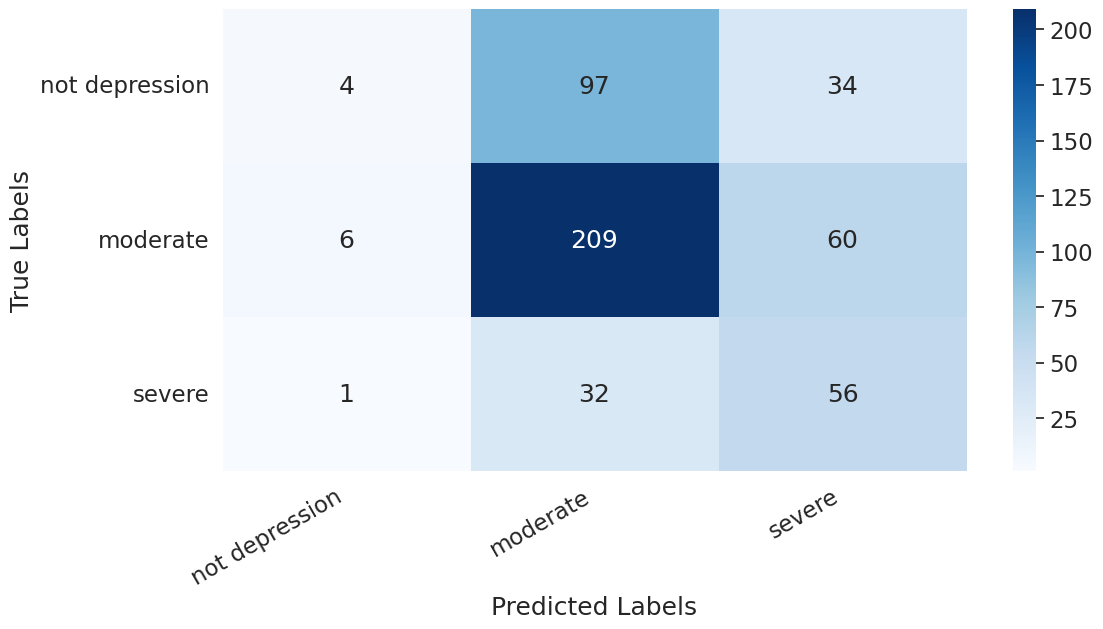

In [ ]:

# Predictions on test provided set
model_1 =  read_a_file('/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/results/test_preds_CLS_Deberta.tsv')
model_2 =  read_a_file('/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/results/test_preds_Max_Pooling_Deberta.tsv')
model_3 =  read_a_file('/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/results/test_preds_Mean_Pooling_Deberta.tsv')
model_4 =  read_a_file('/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/results/BIGRU_Roberta.tsv')

#
# Majority Vote Ensemble on test provided set
merged_preds = pd.concat([model_1.class_label,  model_2.class_label, model_3.class_label], axis = 1)
merged_preds.replace(labels_to_id, inplace = True)
merged_preds = merged_preds.to_numpy()

majority_vote_preds_test = []
for i in range(merged_preds.shape[0]):
  majority_vote_preds_test.append(Counter(merged_preds[i].astype(int)).most_common(1)[0][0])

df_majority_vote_preds_test = pd.DataFrame({'class_label': majority_vote_preds_test})

#df_majority_vote_preds_test.class_label.replace(id_to_labels, inplace = True)
#majority_vote_preds_id_labels_test = pd.concat([test_set.Pid, df_majority_vote_preds_test], axis = 1)

#majority_vote_preds_id_labels_test
#majority_vote_preds_id_labels_test.to_csv('/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/results/' + 'NLP_CHRISTINE_2_Ensemble_models.tsv', encoding = 'utf-8', index = False, header = True, sep ='\t')
model_4.replace(labels_to_id, inplace = True)
calculate_metrics(test_set1.label, df_majority_vote_preds_test.class_label)
#df_majority_vote_preds_test.class_label  model_4.class_label

In [ ]:

# Predictions on developmemt provided set for sub-task A
model_1_dev =  read_a_file('/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/results/dev_set_predictions_CLS_Deberta.tsv')
model_2_dev =  read_a_file('/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/results/dev_set_predictions_Deberta_Max_Pooling.tsv')
model_3_dev =  read_a_file('/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/results/dev_set_predictions_Mean_Pooling_Deberta.tsv')
model_4_dev =  read_a_file('/content/drive/MyDrive/ColabNotebooks/LT-EDI_RANLP_2023/results/dev_set_predictions_BiGRU_Roberta.tsv')

# Majority Vote Ensemble on development set
merged_preds_dev = pd.concat([model_1_dev.class_label,  model_2_dev.class_label, model_3_dev.class_label], axis = 1)
merged_preds_dev.replace(labels_to_id, inplace = True)
merged_preds_dev = merged_preds_dev.to_numpy()

majority_vote_preds_dev = []
for i in range(merged_preds_dev.shape[0]):
  majority_vote_preds_dev.append(Counter(merged_preds_dev[i].astype(int)).most_common(1)[0][0])

df_majority_vote_preds_dev = pd.DataFrame({'class_label': majority_vote_preds_dev})

#df_majority_vote_preds_dev.label_pred.replace(id_to_labels, inplace = True)
#majority_vote_preds_id_labels = pd.concat([development_dataframe.rewire_id, df_majority_vote_preds_dev], axis = 1)
#majority_vote_preds_id_labels.to_csv(args['results_data_directory'] + '6_majority_vote_dev_preds_task_a.csv', encoding = 'utf-8', index = False, header = True, sep =',')
#df_majority_vote_preds_dev.replace(labels_to_id, inplace = True)
calculate_metrics(development_dataframe.label, df_majority_vote_preds_dev.class_label)


**REFERENCE SOURCE CODES**

https://pypi.org/project/focal-loss-torch/

https://github.com/ufoym/imbalanced-dataset-sampler

https://is-rajapaksha.medium.com/bert-word-embeddings-deep-dive-32f6214f02bf

https://www.kaggle.com/code/rhtsingh/utilizing-transformer-representations-efficiently


https://www.kaggle.com/code/joydeb28/text-classification-with-bert-pytorch